# Biweekly Report 4

# Jake Watts

# Data Augmention + Attack

Since the trained model I used to evaluate the attack was trained without data augmentation, I decided to re-train it using data augmentation techniques. These techniques can generally improve model performance and prevent overfitting, however in this report I would like to test if these methods improve robustness against the Fast Sign Gradient Method.

The data augmentation used in this report includes horizontal flipping, horizontal and vertical flipping and pixel erasing randomly applied to the training data for the Xception model. After training thte network I compare the accuracy on testing data with non perturbed images and then perturbed images with epsilon values of .01 and .001 to compare whether the effects are at all mitigated by training with augmented data.

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Add
from tensorflow.keras.layers import SeparableConv2D, ReLU, ELU
from tensorflow.keras.layers import BatchNormalization, MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np

Mounting Google Drive and loading data.

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
def load_data():
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  x_train = x_train.astype('float32') / 255
  x_test = x_test.astype('float32') / 255
  y_train = to_categorical(y_train, 10)
  y_test = to_categorical(y_test, 10)
  return (x_train, y_train), (x_test, y_test)

Function for random erasing to be applied to the training data.

In [4]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w] = c

        return input_img

    return eraser

Loading training and testing data.

In [5]:
(x_train, y_train), (x_test, y_test) = load_data()

170508288/170498071 [==============================] - 11s 0us/step


Functions for convolution and seperable convolutions.

In [6]:
def conv_bn(x, filters, kernel_size, strides=1):
    
    x = Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False)(x)
    x = BatchNormalization()(x)
    return x
# creating separableConv-Batch Norm block

def sep_bn(x, filters, kernel_size, strides=1):
    
    x = SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

Defining the shortened version of the Xception architecture which performed the best in my previous biweekly report.

In [7]:
def entry_flow(x):
    
    x = conv_bn(x, filters =32, kernel_size =3, strides=2)
    x = ELU()(x)
    x = conv_bn(x, filters =64, kernel_size =3, strides=1)
    tensor = ELU()(x)
    
    x = sep_bn(tensor, filters = 128, kernel_size =3)
    x = ELU()(x)
    x = sep_bn(x, filters = 128, kernel_size =3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ELU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = ELU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ELU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = ELU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=728, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    return x
# middle flow

def middle_flow(tensor):
    
    for _ in range(8):
        x = ELU()(tensor)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ELU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ELU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ELU()(x)
        tensor = Add()([tensor,x])
        
        return tensor
# exit flow

def exit_flow(tensor):
    x = GlobalAvgPool2D()(tensor)
    
    x = Dense (units = 10, activation = 'softmax')(x)
    
    return x

Defining model.

In [8]:
input = Input(shape = (32,32,3))
x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)

model = Model (inputs=input, outputs=output)

Setting filepath to save model and defining callbacks options to save the best model, reduce the learning rate if the model is not imporving and end the training if the model is still not improving.

In [12]:
filepath = '/content/gdrive/My Drive/cifar10_xception_aug.h5'

checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
es = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10)

callbacks = [checkpoint, lr_reducer, es]

Defining the image data generator to augment training images.

In [11]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))

Compiling and training the model.

In [13]:
datagen.fit(x_train)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model on the batches generated by datagen.flow().
h_callback = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                       validation_data=(x_test, y_test),
                       epochs=50,
                       callbacks=callbacks)

Epoch 1/50
1563/1563 [==============================] - 57s 25ms/step - loss: 1.5191 - accuracy: 0.4741 - val_loss: 1.4275 - val_accuracy: 0.5536

Epoch 00001: val_loss improved from inf to 1.42753, saving model to /content/gdrive/My Drive/cifar10_xception_aug.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
1563/1563 [==============================] - 38s 24ms/step - loss: 1.1257 - accuracy: 0.6029 - val_loss: 1.4374 - val_accuracy: 0.5670

Epoch 00002: val_loss did not improve from 1.42753
Epoch 3/50
1563/1563 [==============================] - 37s 24ms/step - loss: 0.9811 - accuracy: 0.6563 - val_loss: 0.9108 - val_accuracy: 0.6902

Epoch 00003: val_loss improved from 1.42753 to 0.91077, saving model to /content/gdrive/My Drive/cifar10_xception_aug.h5
Epoch 4/50
1563/1563 [==============================] - 38s 24ms/step - loss: 0.8959 - accuracy: 0.6860 - val_loss: 0.8033 - val_accuracy: 0.7272

Epoch 00004: val_loss improved from 0.91077 to 0.80332, saving model to /content/gdrive/My Drive/cifar10_xception_aug.h5
Epoch 5/50
1563/1563 [==============================] - 39s 25ms/step - loss: 0.8284 - accuracy: 0.7107 - val_loss: 0.7522 - val_accuracy: 0.7454

Epoch 00005: val_loss improved from 0.80332 to 0.75220, saving model to /content/gdrive/My Drive/cifar10_xception_aug.h

Adding data augmentation appears to help the problem I was had in my last biweekly report in which the training accuracy increased to 100% within the first 10 or so epochs while the validation accuracy tended to peak around 75-80%.

In the graph below we can see that the validation accuracy tendes to stay closer to the validation accuracy with the largest gap between the two being about 5-6% as opposed to 25-30% in the last report. Adding data augmentation therfore appears to have been very helpful for model peformance.

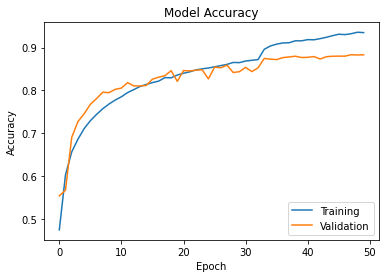

In [14]:
plt.figure()
plt.plot(h_callback.history['accuracy'])
plt.plot(h_callback.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

The accuracy of this model is 88% which is a large improvement over the 80% accuracy without any data augmentation.

In [15]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.3923 - accuracy: 0.8833


[0.3923356235027313, 0.8833000063896179]

Now we can see if the data aumentation helps the performance of the model against the Fast Sign Gradient Method. The code below is the function top create the adversial pattern.

In [16]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

First I create the pertubred images using the first 1000 images in the training data (the same number used on the model without data augmentation) with an epsilon of 0.01. 

In [17]:
(x_train, y_train), (x_test, y_test) = load_data()

size = 1000
x_test_attack = x_test[0:size]

for i in range(size):

  img = tf.convert_to_tensor(x_test[i:i+1], dtype=tf.float32)
  label = tf.convert_to_tensor(y_test[i:i+1], dtype=tf.float32)
  perturbations = create_adversarial_pattern(img, label)

  epsilon = 0.01

  x_test_attack[i] = img + epsilon*perturbations
  x_test_attack[i] = tf.clip_by_value(x_test_attack[i], 0, 1)  

The accuracy on the model without data augmentation for this attack was 11.1% and the accuracy for this model is 11%. Therefore adding data augmentantion did not improve the model's performance when attacked. When using an epsilon of 0.01 both models are essentially useless.

In [18]:
model.evaluate(x_test_attack, y_test[0:size]) 

32/32 [==============================] - 0s 7ms/step - loss: 7.5002 - accuracy: 0.1100


[7.500218391418457, 0.10999999940395355]

Now I change the epsilon value to 0.001 and evaluate the accuracy again. The model without data augmentation had an accuracy rate of 72.7% for this level of epsilon while this model with data augmentation has an accuracy rate of 79.7% meaning it performed better. This result makes sense as the model has a higher accuracy without perturbation so it would follow that the accuracy would be higher with slight perturbation.

In [19]:
(x_train, y_train), (x_test, y_test) = load_data()

size = 1000
x_test_attack = x_test[0:size]

for i in range(size):

  img = tf.convert_to_tensor(x_test[i:i+1], dtype=tf.float32)
  label = tf.convert_to_tensor(y_test[i:i+1], dtype=tf.float32)
  perturbations = create_adversarial_pattern(img, label)

  epsilon = 0.001

  x_test_attack[i] = img + epsilon*perturbations
  x_test_attack[i] = tf.clip_by_value(x_test_attack[i], 0, 1) 

model.evaluate(x_test_attack, y_test[0:size]) 

32/32 [==============================] - 0s 5ms/step - loss: 0.7030 - accuracy: 0.7970


[0.7030179500579834, 0.796999990940094]

# Summary

While adding data augmentation appeared to increase the Xception model's performance without perturbation, it did not appear to improve the model's resistance to the attack. 

Since the Fast Sign Gradient Method changes pixels to maximize the loss function based of gradients after forward propogation, I guess it makes sense that simply adding data augmentation would not help much to defend against attacks. Adding in adversarial images created in a similar way would likely do more to defend agaisnt such attacks.

Although adding data augmentation did not help defend against the attack, it was still useful as it greatly improved model performance and reduced the gap between training and validation accuracy.